In [1]:
import cv2,os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
mask = False
lens = "20"

if mask == True:
    Data_02Nami=np.load("imread_02Namix"+str(lens)+"_mask.npy",allow_pickle=True)
    Data_01=np.load("imread_01x"+str(lens)+"_mask.npy",allow_pickle=True)
else:
    Data_02Nami=np.load("imread_02Namix"+str(lens)+"_nomask.npy",allow_pickle=True)
    Data_01=np.load("imread_01x"+str(lens)+"_nomask.npy",allow_pickle=True)


print("Data_01.shape:", Data_01.shape)
print("Data_02Nami.shape:", Data_02Nami.shape)

Data_01.shape: (45870,)
Data_02Nami.shape: (9321,)


# Padding

In [3]:
if int(lens) == 40:
    Max_shape_0 = 512
    Max_shape_1 = 512
elif int(lens) == 20:
    Max_shape_0 = 256
    Max_shape_1 = 256

In [4]:
#　同じサイズにする
DataPad_01=[]

for img in Data_01:
    imgSize = img.shape
    
    top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2
    left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2
    
    if (imgSize[0] % 2) != 0:
        top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2+1
        
    if (imgSize[1] % 2) != 0:     
        left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2+1
    
    img_pad = cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
  
    DataPad_01.append(img_pad)

print("DataPad_01: ",len(DataPad_01))

DataPad_01:  45870


In [5]:
#　同じサイズにする
DataPad_02Nami=[]

for img in Data_02Nami:
    imgSize = img.shape
    
    top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2
    left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2
    
    if (imgSize[0] % 2) != 0:
        top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2+1
        
    if (imgSize[1] % 2) != 0:     
        left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2+1
    
    img_pad = cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
  
    DataPad_02Nami.append(img_pad)

print("DataPad_02Nami: ",len(DataPad_02Nami))

DataPad_02Nami:  9321


# Split

In [6]:
DataPad_01 = DataPad_01
DataLabel_01 = np.zeros(len(DataPad_01), dtype=np.int)

DataPad_02Nami = DataPad_02Nami
DataLabel_02Nami = np.ones(len(DataPad_02Nami), dtype=np.int)

In [7]:
from sklearn.model_selection import train_test_split

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(DataPad_01, DataLabel_01,
                                                                            test_size=0.3, random_state=42)


X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(DataPad_02Nami, DataLabel_02Nami,
                                                                            test_size=0.3, random_state=42)

X_train, X_test = np.concatenate((X_train_0, X_train_1), axis = 0), np.concatenate((X_test_0, X_test_1), axis = 0)
y_train, y_test = np.concatenate((y_train_0, y_train_1), axis = 0), np.concatenate((y_test_0, y_test_1), axis = 0)


print("Total number of train : ", len(y_train))
print("train_class_0 num : ", y_train.tolist().count(0))
print("train_class_1 num : ", y_train.tolist().count(1))
print("")

print("Total number of test : ", len(y_test))
print("test_class_0 num : ", y_test.tolist().count(0))
print("test_class_1 num : ", y_test.tolist().count(1))

Total number of train :  38633
train_class_0 num :  32109
train_class_1 num :  6524

Total number of test :  16558
test_class_0 num :  13761
test_class_1 num :  2797


# データ前処理

In [8]:
import torch
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
torch.__version__

'1.9.0+cu102'

In [9]:
class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, y_train):
        data = x_train.astype('float32')
        self.x_train = []
        for i in range(data.shape[0]):
            self.x_train.append(Image.fromarray(np.uint8(data[i])))
        self.y_train = y_train
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.transform(self.x_train[idx]), torch.tensor(y_train[idx], dtype=torch.long)

    
class test_dataset(torch.utils.data.Dataset):
    def __init__(self, x_test, y_test):
        data = x_test.astype('float32')
        self.x_test = []
        for i in range(data.shape[0]):
            self.x_test.append(Image.fromarray(np.uint8(data[i])))
        self.y_test = y_test
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_test)

    def __getitem__(self, idx):
        return self.transform(self.x_test[idx]), torch.tensor(y_test[idx], dtype=torch.long)

trainval_data = train_dataset(X_train, y_train)
test_data = test_dataset(X_test, y_test)

In [10]:
batch_size = 32

val_size = int(len(trainval_data)*0.2)
train_size = len(trainval_data) - val_size
print("train_size: ",train_size)
print("val_size: ",val_size)
print("test_size: ",len(y_test))

train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True
)

train_size:  30907
val_size:  7726
test_size:  16558


# ResNet遷移学習

In [11]:
import torch
import torchvision.models as models
import torch.nn as nn

In [12]:
# FC層のクラス数を変更

model = models.resnet101(pretrained=True)
num_fcs = model.fc.in_features

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(
    nn.Linear(num_fcs, 256),
    nn.Dropout(p=0.5),
    nn.ReLU(inplace=True),
    nn.Linear(256, 2)
)

for param in model.fc.parameters():
    param.requires_grad = True
    
model.avgpool = nn.AdaptiveAvgPool2d(1)
model = model.cuda()

In [13]:
n_epochs = 10
lr = 0.01

# negative : ラベル0の数
# positive : ラベル1の数
# weight_for_0 : 1. / negative * (negative + positive)
# weight_for_1 : 1. / positive * (negative + positive)
# class_weight = {0 : weight_for_0, 1 : weight_for_1}
# weights = torch.tensor([(45870+9321)/45870, (45870+9321)/9321]).cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
device = 'cuda'

losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []
    # Train
    model.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = model.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    model.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = model.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))   
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_train))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

/home/acd13264yb/jupyter_env/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 0, Train [Loss: 0.226, Accuracy: 0.918], Valid [Loss: 0.107, Accuracy: 0.963]
EPOCH: 1, Train [Loss: 0.241, Accuracy: 0.885], Valid [Loss: 0.163, Accuracy: 0.963]
EPOCH: 2, Train [Loss: 0.231, Accuracy: 0.887], Valid [Loss: 0.108, Accuracy: 0.966]
EPOCH: 3, Train [Loss: 0.224, Accuracy: 0.887], Valid [Loss: 0.127, Accuracy: 0.941]
EPOCH: 4, Train [Loss: 0.227, Accuracy: 0.886], Valid [Loss: 0.110, Accuracy: 0.960]
EPOCH: 5, Train [Loss: 0.227, Accuracy: 0.888], Valid [Loss: 0.184, Accuracy: 0.832]
EPOCH: 6, Train [Loss: 0.263, Accuracy: 0.848], Valid [Loss: 0.159, Accuracy: 0.968]
EPOCH: 7, Train [Loss: 0.257, Accuracy: 0.856], Valid [Loss: 0.142, Accuracy: 0.960]
EPOCH: 8, Train [Loss: 0.256, Accuracy: 0.854], Valid [Loss: 0.154, Accuracy: 0.962]
EPOCH: 9, Train [Loss: 0.264, Accuracy: 0.844], Valid [Loss: 0.158, Accuracy: 0.966]


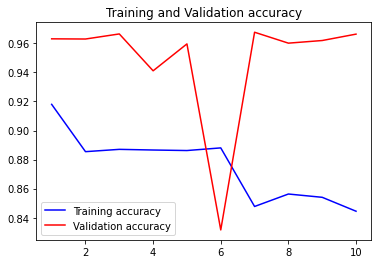

<Figure size 432x288 with 0 Axes>

In [14]:
# train processing plot
epochs=range(1,n_epochs+1)

plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

In [15]:
losses_test = []
n_test = 0
acc_test = 0
model.eval()

for x, t in dataloader_test:
        n_test += t.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = model.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_test += (pred == t).float().sum().item()
        losses_test.append(loss.tolist())

# Visualize loss & accuracy 
print("acc_test: ", acc_test) 
print("n_test: ", n_test)
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(np.mean(losses_test),acc_test/n_test))

acc_test:  16020.0
n_test:  16558
Loss: 0.159, Accuracy: 0.968
